In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
sys.path.append("../data/biasbios")
sys.path.append("../data/embeddings/biasbios")
import classifier
import debias
import gensim
import codecs
import json
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import DictVectorizer
from pytorch_transformers import BertTokenizer, BertModel, BertForMaskedLM

import scipy
from scipy import linalg
from scipy import sparse
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier, SGDRegressor, Perceptron, LogisticRegression
from sklearn.utils import shuffle

%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000

import warnings
warnings.filterwarnings("ignore")

import pickle
from collections import defaultdict, Counter
from typing import List, Dict

import torch
from torch import utils

import pytorch_lightning as pl
from pytorch_lightning import Trainer
import copy
import pandas as pd
from gensim.models import FastText
import time
from gensim.scripts.glove2word2vec import glove2word2vec

STOPWORDS = set(["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"])

unable to import 'smart_open.gcs', disabling that module


In [2]:


def load_dataset(path):
    
    with open(path, "rb") as f:
        
        data = pickle.load(f)
    return data

def load_dictionary(path):
    
    with open(path, "r", encoding = "utf-8") as f:
        
        lines = f.readlines()
        
    k2v, v2k = {}, {}
    for line in lines:
        
        k,v = line.strip().split("\t")
        v = int(v)
        k2v[k] = v
        v2k[v] = k
    
    return k2v, v2k
    
def count_profs_and_gender(data: List[dict]):
    
    counter = defaultdict(Counter)
    for entry in data:
        gender, prof = entry["g"], entry["p"]
        counter[prof][gender] += 1
        
    return counter


In [3]:
train = load_dataset("../data/biasbios/train.pickle")
dev = load_dataset("../data/biasbios/dev.pickle")
test = load_dataset("../data/biasbios/test.pickle")

p2i, i2p = load_dictionary("../data/biasbios/profession2index.txt")
g2i, i2g = load_dictionary("../data/biasbios/gender2index.txt")
counter = count_profs_and_gender(train+dev+test)

In [395]:
train[0]

{'g': 'f',
 'p': 'professor',
 'text': 'Dr. Elizabeth Armstrong-Mensah is a clinical assistant professor in the Undergraduate Program at the School of Public Health at Georgia State University. She teaches Introduction to Chronic and Infectious Diseases, Health Equity and Disparities: Urban and Global Health Challenges, and Introduction to Program Implementation and Evaluation. Dr. Armstrong-Mensah previously taught Global Health to students enrolled in the Schools Master of Public Health Program.',
 'start': 153,
 'hard_text': 'She teaches Introduction to Chronic and Infectious Diseases, Health Equity and Disparities: Urban and Global Health Challenges, and Introduction to Program Implementation and Evaluation. Dr. Armstrong-Mensah previously taught Global Health to students enrolled in the Schools Master of Public Health Program.',
 'text_without_gender': '_ teaches Introduction to Chronic and Infectious Diseases, Health Equity and Disparities: Urban and Global Health Challenges, and

In [5]:
print(p2i)

{'accountant': 0, 'architect': 1, 'attorney': 2, 'chiropractor': 3, 'comedian': 4, 'composer': 5, 'dentist': 6, 'dietitian': 7, 'dj': 8, 'filmmaker': 9, 'interior_designer': 10, 'journalist': 11, 'model': 12, 'nurse': 13, 'painter': 14, 'paralegal': 15, 'pastor': 16, 'personal_trainer': 17, 'photographer': 18, 'physician': 19, 'poet': 20, 'professor': 21, 'psychologist': 22, 'rapper': 23, 'software_engineer': 24, 'surgeon': 25, 'teacher': 26, 'yoga_teacher': 27}


In [6]:
counter = count_profs_and_gender(train+dev+test)
f,m = 0., 0.
prof2fem = dict()

for k, values in counter.items():
    f += values['f']
    m += values['m']
    prof2fem[k] = values['f']/(values['f'] + values['m'])

print(f / (f + m))
print(prof2fem)

0.46286566875856267
{'professor': 0.45118956904580476, 'chiropractor': 0.26558891454965355, 'psychologist': 0.6223011751844766, 'architect': 0.23712053792148718, 'physician': 0.507688318423441, 'nurse': 0.9085446207369142, 'dentist': 0.35589474411216243, 'surgeon': 0.14857228961048746, 'rapper': 0.09665955934612651, 'model': 0.8283124500133298, 'photographer': 0.35721920736720936, 'composer': 0.16392857142857142, 'comedian': 0.21150410861021793, 'filmmaker': 0.3295762590954487, 'paralegal': 0.8483305036785512, 'journalist': 0.49488721804511276, 'personal_trainer': 0.45670391061452514, 'teacher': 0.603111879476414, 'painter': 0.4579886246122027, 'attorney': 0.38316925813475633, 'accountant': 0.36818825194621374, 'software_engineer': 0.1576889661164205, 'poet': 0.49080017115960634, 'dj': 0.1420875420875421, 'pastor': 0.24052132701421802, 'yoga_teacher': 0.8454600120264583, 'dietitian': 0.9273504273504274, 'interior_designer': 0.8086124401913876}


In [7]:
print(p2i)

{'accountant': 0, 'architect': 1, 'attorney': 2, 'chiropractor': 3, 'comedian': 4, 'composer': 5, 'dentist': 6, 'dietitian': 7, 'dj': 8, 'filmmaker': 9, 'interior_designer': 10, 'journalist': 11, 'model': 12, 'nurse': 13, 'painter': 14, 'paralegal': 15, 'pastor': 16, 'personal_trainer': 17, 'photographer': 18, 'physician': 19, 'poet': 20, 'professor': 21, 'psychologist': 22, 'rapper': 23, 'software_engineer': 24, 'surgeon': 25, 'teacher': 26, 'yoga_teacher': 27}


### get input representatons 

In [342]:

def load_word_vectors(fname):
    
    model = KeyedVectors.load_word2vec_format(fname, binary=False)
    vecs = model.vectors
    words = list(model.vocab.keys())
    return model, vecs, words


def get_embeddings_based_dataset(data: List[dict], word2vec_model, p2i, filter_stopwords = False):
    
    X, Y = [], []
    unk, total = 0., 0.
    unknown = []
    vocab_counter = Counter()
    
    for entry in tqdm.tqdm_notebook(data, total = len(data)):
        
        y = p2i[entry["p"]]
        words = entry["hard_text_tokenized"].split(" ")
        if filter_stopwords:
            words = [w for w in words if w.lower() not in STOPWORDS]
            
        vocab_counter.update(words) 
        bagofwords = np.sum([word2vec_model[w] if w in word2vec_model else word2vec_model["unk"] for w in words], axis = 0)
        #print(bagofwords.shape)
        X.append(bagofwords)
        Y.append(y)
        total += len(words)
        
        unknown_entry = [w for w in words if w not in word2vec_model]
        unknown.extend(unknown_entry)
        unk += len(unknown_entry)
    
    X = np.array(X)
    Y = np.array(Y)
    print("% unknown: {}".format(unk/total))
    return X,Y,unknown,vocab_counter



In [9]:
word2vec, vecs, words = load_word_vectors("../data/embeddings/crawl-300d-2M.vec")

In [343]:

X_train, Y_train, unknown_train, vocab_counter_train = get_embeddings_based_dataset(train, word2vec, p2i)
X_dev, Y_dev, unknown_dev, vocab_counter_dev =  get_embeddings_based_dataset(dev, word2vec, p2i)
X_test, Y_test, unknown_test, vocab_counter_test =  get_embeddings_based_dataset(test, word2vec, p2i)


% unknown: 0.010627311749300124



% unknown: 0.01063013204741088



% unknown: 0.010614138942311224


In [356]:
def save_in_word2vec_format(vecs: np.ndarray, words: np.ndarray, fname: str):


    with open(fname, "w", encoding = "utf-8") as f:

        f.write(str(len(vecs)) + " " + "300" + "\n")
        for i, (v,w) in tqdm.tqdm_notebook(enumerate(zip(vecs, words))):

            vec_as_str = " ".join([str(x) for x in v])
            f.write(w + " " + vec_as_str + "\n")


vocab_bios, _ = list(zip(*vocab_counter_train.most_common(120000)))
words_set = set(words)
vocab_bios = [w for w in tqdm.tqdm_notebook(vocab_bios) if w in words_set]
vecs_for_vocab = np.array([word2vec[w] for w in tqdm.tqdm_notebook(vocab_bios)])
print("here")
save_in_word2vec_format(vecs_for_vocab, vocab_bios, "vecs.vocab.bios.txt")
word2vec_bios, _, _ = load_word_vectors("vecs.vocab.bios.txt")


here


In [14]:

print("len train: {}; len dev: {}; len test: {}".format(len(train), len(dev), len(test)))
mean_train = np.mean(X_train, axis = 0, keepdims = True)
mean_dev = np.mean(X_dev, axis = 0, keepdims = True)
mean_test = np.mean(X_test, axis = 0, keepdims = True)

#X_train -= mean_train
#X_dev -= mean_dev
#X_test -= mean_test

len train: 255682; len dev: 39362; len test: 98379


## Classify by profession

In [444]:
#clf = LinearSVC(max_iter = 10) #LogisticRegression()
#clf = SGDClassifier(warm_start = True, loss = 'log', n_jobs = 64, max_iter = 250, random_state = 0)

clf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", multi_class = 'multinomial', fit_intercept = True,
                         verbose = 10, max_iter = 4, n_jobs = 64, random_state = 1)
#clf = SGDClassifier(loss= 'log', max_iter= 3000, fit_intercept= True, class_weight= None, n_jobs= 100)
#clf = LinearSVC(max_iter = 50) #LogisticRegression()

start = time.time()
idx = np.random.rand(X_train.shape[0]) < 1.0
clf.fit(X_train[idx], Y_train[idx])
print("time: {}".format(time.time() - start))
print(clf.score(X_dev, Y_dev))
#print(clf.score(X_test, Y_test))
clf_original = copy.deepcopy(clf)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 37 seconds
time: 37.411365032196045
0.7844367664244704


[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:   36.8s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   36.8s finished


In [446]:
print(clf.score(X_test, Y_test))


0.7817013793594161


#### Confusion Matrix

### perform debiasing

In [432]:
def get_projection_matrix(num_clfs, X_train, Y_train, X_dev, Y_dev, Y_train_task, Y_dev_task, dim, all_data_prob, by_class = False):

    is_autoregressive = True
    min_acc = 0.
    dim = 300
    n = num_clfs
    random_subset = 1
    start = time.time()
    TYPE= "svm"
    penalty = "l2"
    MLP = False
    
    if MLP:
        x_train_gender = np.matmul(X_train, clf.coefs_[0]) + clf.intercepts_[0]
        x_dev_gender = np.matmul(X_dev, clf.coefs_[0]) + clf.intercepts_[0]
    else:
        x_train_gender = X_train.copy()
        x_dev_gender = X_dev.copy()
        
    
    if TYPE == "sgd":
        print("using sgd")
        gender_clf = SGDClassifier
        params = {'alpha': 0.01, 'penalty': penalty, 'loss': 'hinge', 'fit_intercept': True, 'class_weight': "balanced", 'n_jobs': 16}
    elif TYPE == "svm":
        gender_clf = LinearSVC
        params = {'fit_intercept': True, 'C': 0.3, 'class_weight': None, "dual": False}
    elif TYPE == "perceptron":
        gender_clf = Perceptron
        params = {'max_iter': 1000, 'fit_intercept': True, 'class_weight': None}
    elif TYPE == "logistic":
        gender_clf = LogisticRegression
        params = {}
        
    result = debias.get_debiasing_projection(gender_clf, params, n, dim, is_autoregressive, min_acc,
                                              x_train_gender, Y_train, x_dev_gender, Y_dev,
                                       Y_train_main=Y_train_task, Y_dev_main=Y_dev_task, 
                                        by_class = by_class)
    print("time: {}".format(time.time() - start))
    return result

# was c=0.15, num_clfs=130
num_clfs = 150
Y_dev_gender = np.array([g2i[d["g"]] for d in dev])
Y_test_gender = np.array([g2i[d["g"]] for d in test])
Y_train_gender = np.array([g2i[d["g"]] for d in train])
P, rowspace_projs, Ws = get_projection_matrix(num_clfs, X_train, Y_train_gender, X_dev, Y_dev_gender, Y_train, Y_dev, 300, 0.0, by_class= True)




iteration: 41, accuracy: 0.9062170706006323:  28%|██▊       | 42/150 [02:52<10:55,  6.07s/it]


iteration: 83, accuracy: 0.8509036144578314:  56%|█████▌    | 84/150 [05:43<03:44,  3.39s/it]


iteration: 125, accuracy: 0.6171060698957694:  83%|████████▎ | 125/150 [08:56<02:24,  5.79s/it]


iteration: 149, accuracy: 0.644471845458282: 100%|██████████| 150/150 [11:20<00:00,  4.53s/it]


time: 680.8837802410126


In [433]:
with open("P.bios.fasttext.{}.svm.pickle".format(num_clfs), "wb") as f:
    
    pickle.dump(P, f)
    
np.linalg.norm(Ws[-1])

0.0359097336267707

In [434]:
Ws[-50].dot(Ws[0].T)

array([[-3.8520619e-14]])

In [435]:
gender_clf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", multi_class = 'multinomial', fit_intercept = True,
                         verbose = 10, max_iter = 7, n_jobs = 64, random_state = 1)

gender_clf.fit(P.dot(X_train.T).T, Y_train_gender)
gender_clf.score(P.dot(X_dev.T).T, Y_dev_gender)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 7 seconds


[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    7.0s finished


0.572531883542503

In [436]:
gender_clf.score(P.dot(X_train.T).T, Y_train_gender)

0.5728600370773069

### Perform finetuning

In [455]:

clf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", multi_class = 'multinomial', fit_intercept = True,
                         verbose = 10, max_iter = 6, n_jobs = 64, random_state = 0, class_weight = None)
# 5
#clf = SGDClassifier(verbose=10, n_jobs = 32)
clf.fit(P.dot(X_train.T).T, Y_train)
#clf.fit(X_train, Y_train)


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 53 seconds


[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:   52.8s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   52.8s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=6,
                   multi_class='multinomial', n_jobs=64, penalty='l2',
                   random_state=0, solver='sag', tol=0.0001, verbose=10,
                   warm_start=True)

In [457]:
print(clf.score(P.dot(X_test.T).T, Y_test))

0.7307657121946757


#### test again

In [458]:
def get_TPR(y_pred, y_true, p2i, i2p, gender):
    
    scores = defaultdict(Counter)
    prof_count_total = defaultdict(Counter)
    
    assert len(y_pred) == len(y_true) == len(gender)
               
    for y_hat, y, g in zip(y_pred, y_true, gender):
                
        if y == y_hat:
            
            scores[i2p[y]][g] += 1
        
        prof_count_total[i2p[y]][g] += 1
    
    tprs = defaultdict(dict)
    tprs_change = dict()
    tprs_ratio = []
    
    for profession, scores_dict in scores.items():
        
        good_m, good_f = scores_dict["m"], scores_dict["f"]
        prof_total_f = prof_count_total[profession]["f"]
        prof_total_m = prof_count_total[profession]["m"]
        tpr_m = (good_m) / prof_total_m
        tpr_f = (good_f) / prof_total_f
        
        tprs[profession]["m"] = tpr_m
        tprs[profession]["f"] = tpr_f
        tprs_ratio.append(0)
        tprs_change[profession] = tpr_f - tpr_m
        
    return tprs, tprs_change, np.mean(np.abs(tprs_ratio))

def get_FPR(y_pred, y_true, p2i, i2p, gender):
    
    fp = defaultdict(Counter)
    neg_count_total = defaultdict(Counter)
    pos_count_total = defaultdict(Counter)
    
    
               
    for y_hat, y, g in zip(y_pred, y_true, gender):
        
        if y != y_hat:
            
            fp[i2p[y_hat]][g] += 1 # count false positives for y_hat
        
        neg_count_total[i2p[y_hat]][g] += 1 # count "not y_hat"
                
    fprs = defaultdict(dict)
    fprs_change = dict()
    fprs_ratio = []
    
    #print(prof_count_total)
    
    for profession, scores_dict in fp.items():
        
        good_m, good_f = scores_dict["m"], scores_dict["f"]
        prof_total_f = neg_count_total[profession]["f"]
        prof_total_m = neg_count_total[profession]["m"]
        print(profession)
        fpr_m = (good_m+good_f) / prof_total_m
        fpr_f = (good_m+good_f) / prof_total_f
        
        fprs[profession]["m"] = fpr_m
        fprs[profession]["f"] = fpr_f
        fprs_ratio.append(0)
        fprs_change[profession] = fpr_m - fpr_f
        
    return fprs, fprs_change, np.mean(np.abs(fprs_ratio))    
    
def similarity_vs_tpr(tprs, word2vec, title, measure, prof2fem):
    
    professions = list(tprs.keys())
    #
    """ 
    sims = dict()
    gender_direction = word2vec["he"] - word2vec["she"]
    
    for p in professions:
        sim = word2vec.cosine_similarities(word2vec[p], [gender_direction])[0]
        sims[p] = sim
    """
    tpr_lst = [tprs[p] for p in professions]
    sim_lst = [prof2fem[p] for p in professions]

    #professions = [p.replace("_", " ") for p in professions if p in word2vec]
    
    plt.plot(sim_lst, tpr_lst, marker = "o", linestyle = "none")
    plt.xlabel("% women", fontsize = 13)
    plt.ylabel(r'$GAP_{female,y}^{TPR}$', fontsize = 13)
    for p in professions:
        x,y = prof2fem[p], tprs[p]
        plt.annotate(p , (x,y), size = 7, color = "red")
    
    plt.ylim(-0.4,0.55)
    z = np.polyfit(sim_lst, tpr_lst, 1)
    p = np.poly1d(z)
    plt.plot(sim_lst,p(sim_lst),"b--")

    plt.savefig("{}_vs_bias_{}_fasttext".format(measure, title), dpi = 600)
    print("Correlation: {}; p-value: {}".format(*pearsonr(sim_lst, tpr_lst)))
    plt.show()
    
def rms_diff(tpr_diff):
    
    return np.sqrt(np.mean(tpr_diff**2))
    
def save_vecs_and_words(vecs, words):
    def to_string(arr):
        return "\t".join([str(x) for x in arr])
    
    with open("vecs.txt", "w") as f:
        for v in vecs:
            assert len(v) == 300
            f.write(to_string(v) + "\n")
    
    with open("labels.txt", "w") as f:
            f.write("Profession\n")
            for w in words:
                f.write(w + "\n")

Correlation: 0.896128365939987; p-value: 1.1505863096767978e-10


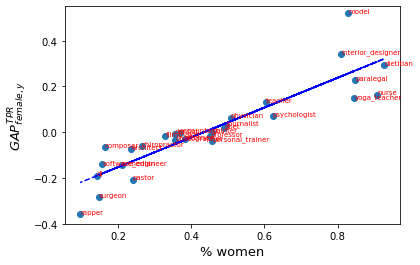

Correlation: 0.42508979377460765; p-value: 0.024134416009542383


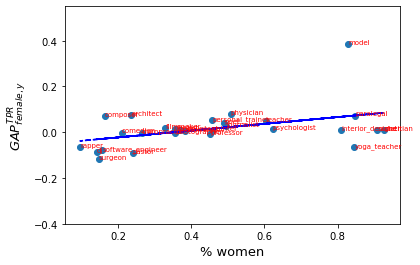

rms-diff before: 0.18401432640154125; rms-diff after: 0.08929191298841939


In [459]:


y_pred_before = clf_original.predict(X_test)
test_gender = [d["g"] for d in test]
dev_gender = [d["g"] for d in dev]
train_gender = [d["g"] for d in train]

tprs_before, tprs_change_before, mean_ratio_before = get_TPR(y_pred_before, Y_test, p2i, i2p, test_gender)
similarity_vs_tpr(tprs_change_before, word2vec, "before", "TPR", prof2fem)


#y_pred_after = clf.predict(X_test.dot(P))
y_pred_after = clf.predict(X_test.dot(P))
tprs, tprs_change_after, mean_ratio_after = get_TPR(y_pred_after, Y_test, p2i, i2p, test_gender)
similarity_vs_tpr(tprs_change_after, word2vec, "after", "TPR", prof2fem)

change_vals_before = np.array(list((tprs_change_before.values())))
change_vals_after = np.array(list(tprs_change_after.values()))

print("rms-diff before: {}; rms-diff after: {}".format(rms_diff(change_vals_before), rms_diff(change_vals_after)))

In [441]:
def tsne_by_gender(vecs, labels, title, words = None):

  tsne = TSNE(n_components=2, random_state=0)
  vecs_2d = tsne.fit_transform(vecs)
  num_labels = len(set(labels.tolist()))

  names = ["class {}".format(i) for i in range(num_labels)]
  plt.figure(figsize=(6, 5))
  colors = 'r', 'b', 'orange'
  for i, c, label in zip(set(labels.tolist()), colors, names):
    print(len(vecs_2d[labels == i, 0]))
    plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                label=label, alpha = 0.6)
  plt.legend(loc = "upper right")
  plt.title(title)
  
  if words is not None:
        k = 60
        for i in range(k):
            
            j = np.random.choice(range(len(words)))
            label = labels[i]
            w = words[j]
            x,y = vecs_2d[i]
            plt.annotate(w , (x,y), size = 10, color = "black" if label == 1 else "black")
            
  plt.show()
  return vecs_2d

427
373


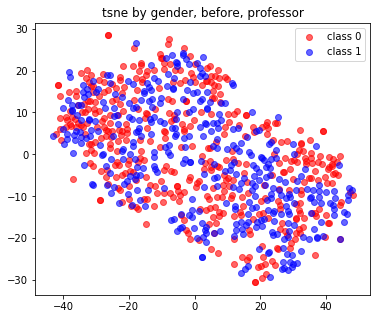

427
373


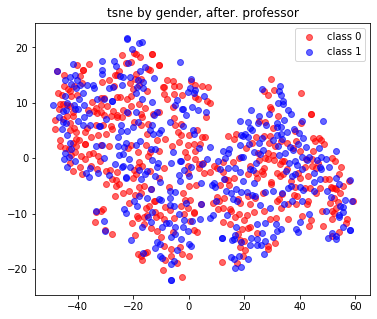

array([[ 32.485493 ,  12.184171 ],
       [ 35.634182 ,  -8.2724495],
       [-17.2829   ,  -6.3334994],
       ...,
       [-36.05815  ,   0.7407745],
       [ -6.674764 ,  -9.3163595],
       [-45.375324 ,   8.504394 ]], dtype=float32)

In [442]:
prof = "professor"
idx = np.random.rand(X_dev.shape[0]) < 0.1
prof_idx = Y_dev == p2i[prof]
n = 800
tsne_by_gender(X_dev[prof_idx][:n], np.array(dev_gender)[prof_idx][:n], "tsne by gender, before, {}".format(prof))
tsne_by_gender((X_dev[prof_idx].dot(P))[:n], np.array(dev_gender)[prof_idx][:n], "tsne by gender, after. {}".format(prof))

In [ ]:
def count_profs(data_y, i2p):
    d = Counter()
    for y in data_y:
        d[i2p[y]] += 1
    return d

In [ ]:
count_profs(Y_train, i2p)

In [ ]:
count_profs(Y_dev, i2p)

In [ ]:
p0 = all_Ps[0]
p1 = all_Ps[1]
p2 = all_Ps[2]

In [34]:
p2.dot(p2.T)<

SyntaxError: invalid syntax (<ipython-input-34-bb1006037f2f>, line 1)

In [ ]:
p0 = all_Ps[0]
p1 = all_Ps[1]
p2 = all_Ps[2]

p2.dot(p2.T)

In [ ]:
def get_common_words(data: List[dict], word2vec_model):
    
    words_counter = Counter()
    vecs = []
    all_words = []
    
    
    for entry in tqdm.tqdm(data, total = len(data)):
        
        y = p2i[entry["p"]]
        words = entry["hard_text"].split(" ")
        all_words.extend(words)
            
    
    words_counter = Counter(all_words)
    common_words = [w for w in words_counter if words_counter[w] > 10 and (w in word2vec_model)]
    common_vecs = [word2vec_model[w] for w in common_words]
    
    return common_words, common_vecs
        
        

In [ ]:
words, vecs = get_common_words(train,word2vec)

vecs_normed = vecs / np.linalg.norm(vecs, keepdims = True)
ws_normed = [w/np.linalg.norm(w) for w in all_ws]
k = 1000
groups, labels = [], []

for i,w in enumerate(ws_normed):
    print("INLP ITERATION: {}".format(i))
    sims_i = w.dot(vecs_normed.T).squeeze(0)
    zipped = zip(words, vecs_normed, sims_i)
    zipped = sorted(list(zipped), key = lambda tuple: -abs(tuple[2]))
    ws,vs, sims = list(zip(*zipped))
    print(ws[:k])
    groups.append(vs[:k])
    labels.append(i)
    print("------------------------------------------------------------------")

In [ ]:
def visualize_gender_subspace(vecs, labels):
    
        N = len(labels)
        
        all_vecs = []
        all_labels = []
        
        for vecs_list,l in zip(vecs, labels):
            
            all_labels.append(np.ones(len(vecs_list)) * l)
        
        all_vecs_np = np.concatenate(vecs, axis = 0)
        all_labels_np = np.concatenate(all_labels, axis = 0)
        tsne = TSNE(n_components=2, random_state=0)
        vecs_2d = tsne.fit_transform(all_vecs_np)
    
        fig, ax = plt.subplots()
        # define the colormap
        cmap = plt.cm.jet
        # extract all colors from the .jet map
        cmaplist = [cmap(i) for i in range(cmap.N)]
        # create the new map
        cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
        # define the bins and normalize
        bounds = np.linspace(0, N, N + 1)
        norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
        print("here")
        print(all_labels_np.shape)
        scat = ax.scatter(vecs_2d[:,0], vecs_2d[:,1], c=all_labels_np, cmap=cmap, norm=norm, alpha=0.15)
        cb = plt.colorbar(scat, spacing='proportional')#, ticks=bounds)
        cb.set_label("INLP iteration number")
        plt.savefig("INLP progress", dpi = 600)
        plt.show()

In [ ]:
#visualize_gender_subspace(groups, labels)

In [ ]:
word2vec

In [362]:
i = 0
for w in Ws[:150]:
    
    #sims = word2vec.similar_by_vector(-w.squeeze(), topn = 60, restrict_vocab=None)
    most_similar_f, _ =  list(zip(*word2vec_bios.similar_by_vector(w.squeeze(), topn = 20, restrict_vocab=None)))
    most_similar_m, _ =  list(zip(*word2vec_bios.similar_by_vector(-w.squeeze(), topn = 20, restrict_vocab=None)))
    print("gender direction {}.\n most_similar male: {}\n; most_similar female: {}".format(i, most_similar_m, most_similar_f))
    print("=====================================")
    i += 1

gender direction 0.
 most_similar male: ('himself', 'his', 'he', 'Fatherhood', 'His', 'vExpert', 'Freemasonry', 'He', 'Topman', 'fatherhood', 'Grails', 'homoerotic', 'everyman', 'FanDuel', 'Masonry', 'VMworld', 'varicocele', '.His', 'journeyman', 'APEX')
; most_similar female: ('herself', 'she', 'her', 'She', 'Her', 'hers', 'Carolyn', 'Colleen', 'Susan', 'Diane', '.She', 'Ms.', 'Kathleen', 'Chairwoman', 'Kathryn', 'Laura', 'Kathy', 'Alyssa', 'Karen', 'Tricia')
gender direction 1.
 most_similar male: ('shortwave', 'E.F.', 'Henceforth', 'R.T.', 'Rattling', 'CMG', 'SGM', 'GMR', 'microstructure', 'faithfully', 'periodically', 'Wyner', 'SPT', 'impulse', 'W.R.', 'henceforth', 'J.E.', 'mesoscale', 'maestro', 'urges')
; most_similar female: ('Childbirth', 'Yoga', 'Hatha', 'Midwifery', 'Pregnancy', 'pregnancy', 'yoga', 'Maternity', 'yoginis', 'Childbearing', 'Asana', 'YOGA', 'childbirth', 'midwifery', 'YogaWorks', 'Intimates', 'Jivamukti', 'AcroYoga', 'motherhood', 'maternity')
gender direction

gender direction 16.
 most_similar male: ('Azab', 'Assi', 'Headliners', 'rammed', 'main', 'Loconte', 'AFP', 'Faux', 'Antiwar.com', 'millimeter', 'Zig', 'expounds', 'Yad', 'animating', 'MERS', 'Propagation', 'rails', 'propagation', 'extrema', 'collapsed')
; most_similar female: ('Nest', 'poems', 'Haiku', 'Poems', 'poem', 'POEM', 'solitude', 'PANK', 'poet', 'LARK', 'Reveries', 'sweetheart', 'elegies', 'moniker', 'Hawthornden', 'Peranakan', 'sobriquet', 'Ramanujan', 'mama', 'smart')
gender direction 17.
 most_similar male: ('Idiom', 'Raiders', 'Rodel', 'Swalwell', 'Raka', 'McNair', 'Spindrift', 'Mcnair', 'Vikings', 'Whiz', 'Dunmore', 'Hampton', 'OJ', 'Merriman', 'NHBA', '7011', 'Baffert', 'Tulley', 'Harlene', 'Excelsior')
; most_similar female: ('Lambda', 'RNAs', 'Granade', 'VDI', 'Curves', 'MIRA', 'Glamour', 'LiDAR', 'Inked', 'PLOS', 'heterosexual', 'lobe', 'carnivore', 'Ceph', 'MAV', 'sexes', 'Palimpsest', 'Complutense', 'MATLAB', 'Département')
gender direction 18.
 most_similar male: 

gender direction 35.
 most_similar male: ('poodle', 'fluffy', 'poodles', 'Goldendoodle', 'schnauzer', 'ditzy', 'darling', 'dreamy', 'delicate', 'dachshunds', 'Javaheri', 'leggy', 'angelic', 'Farshid', 'Julee', 'Zilker', 'Chelsi', 'scrumptious', 'Heidi', 'embellishments')
; most_similar female: ('Ss', 'Corman', 'Handed', 'Sell', 'Fly', 'LD', 'Pay', 'dimorphism', 'Eynde', 'indicator', 'ACP', 'Coffin', 'Ca', 'Aware', 'Paid', 'Bottle', 'Differently', 'rites', 'pay', 'Detect')
gender direction 36.
 most_similar male: ('Papanikolaou', 'Bersani', 'Chihara', 'Violi', 'Bernardi', 'Risch', 'Hamori', 'Appearing', 'Fabius', 'aplomb', 'Kokas', 'invitations', 'Papaconstantinou', 'Bartschi', 'Camilleri', 'Noblet', 'Yokomizo', 'Albanese', 'premiers', 'Frattini')
; most_similar female: ('SAI', 'Burrough', 'MMS', 'RISC', 'OI', 'MMU', 'SLF', 'FLL', 'HMP', 'shorted', 'BAH', 'LEF', 'CMP', 'VCO', 'Tektronix', 'HUM', 'BPC', 'EME', 'DFN', 'NI')
gender direction 37.
 most_similar male: ('Bang', 'Money', '6x6',

gender direction 55.
 most_similar male: ('Cenac', 'Gilfillan', 'Ghouse', 'Rothberg', 'Talwar', 'McGillivray', 'Loughlin', 'Maclean', 'Purdey', 'Schorr', 'Spinella', 'Saperstein', 'manifold', 'Carrell', 'Mazzei', 'Valiant', 'Rigg', 'Chisholm', 'Advani', 'Ruffalo')
; most_similar female: ('AUP', 'cyberpunk', 'tos', 'Troopers', 'interlocal', 'assignement', 'netlabel', 'GNU', 'PED', 'Aomori', 'Paintsville', 'po', 'intermedia', 'carpal', 'github', 'Symfony2', 'ville', 'Lona', 'Kaiapoi', 'parapsychological')
gender direction 56.
 most_similar male: ('Palatka', 'Slocumb', 'Wests', 'Opdyke', 'LaCrosse', 'Wasco', 'Designers', 'Kucha', 'Dowdy', 'Kaukauna', 'Westfield', 'Lamson', 'Should', 'Brookville', 'Goodyear', 'Wainscott', 'Bechers', 'Elco', 'Allworth', 'Millville')
; most_similar female: ('caseworker', 'Sociale', 'penpal', 'Volunteering', 'monitor', 'adjust', 'Reintegration', 'LGBTI', 'monitoring', 'Aftercare', 'clinic-', 'volunteering', 'see', 'waitlists', 'reintegration', 'VSO', 'cultura

gender direction 74.
 most_similar male: ('entice', 'not', 'Peirce', 'Durgin', 'teaser', 'Courant', 'vagueness', 'adjectives', 'descriptive', 'Rendell', 'persuade', 'ought', 'Propositions', 'Culliton', 'description', 'EPPA', 'Lussier', 'coin', 'might', 'propositions')
; most_similar female: ('Zhanna', 'choreographing', 'logistical', 'Eurosport', 'YMT', 'choreographs', 'Rostov', 'Baku', 'aerials', 'upmost', 'spectating', 'Shanghainese', 'epicentre', 'parental', 'hora', 'T1D', 'bespoke', 'orchestrates', 'Dynastic', 'interruptions')
gender direction 75.
 most_similar male: ('mythological', 'Maratha', 'ideological', 'nationalistic', 'historical', 'nationalist', 'militarized', 'microbiological', 'heritage', 'historiographic', 'bureaucratic', 'Ossetian', 'scientific', 'mythical', 'Bicentenary', 'Odissi', 'missionary', 'Afrikaner', 'Kuka', 'delegations')
; most_similar female: ('admit', 'Bornstein', 'LL', 'Mcgee', 'Kaz', 'Biddle', 'Attell', 'Wiz', 'Hebb', 'Reggie', 'Golson', 'McNally', 'Ullma

gender direction 93.
 most_similar male: ('shoulders', 'weakened', 'modifier', 'competed', 'compete', 'shoulder', 'grappled', 'braces', 'bows', 'decorate', 'weaker', 'qualifiers', 'solidify', 'Braces', 'PRODUCTS', 'top', 'icing', 'piping', 'grabs', 'squeezed')
; most_similar female: ('reincarnation', 'Airpark', 'Ctr', 'madness', 'painless', 'Tun', 'eugenics', 'resort', 'millenials', 'martinis', 'Deming', 'Spira', 'Tread', 'folly', 'Th', 'fusion', 'Interval', 'Reynolda', 'paradoxes', 'quaint')
gender direction 94.
 most_similar male: ('cup', 'kissed', 'Shade', 'kiss', 'adoration', 'Sailor', 'Lalah', 'stroll', 'infatuation', 'download', 'escort', 'Prince', 'Nerds', 'shake', 'Ishq', 'Alto', 'Morning', 'sake', 'Sake', 'Nylon')
; most_similar female: ('ACLA', 'RFE', 'extracorporeal', 'ILSI', 'NAACL', 'AstraZeneca', 'Paleontological', 'Mallinckrodt', 'EMNLP', 'Medstat', 'CJA', 'ILP', 'Iterative', 'IPPE', 'AHFMR', 'CDCI', 'nongovernmental', 'CIGNA', 'LINGUIST', 'CRNI')
gender direction 95.
 m

gender direction 112.
 most_similar male: ('securitized', 'numerics', 'topologies', 'topology', 'topological', 'syllabic', 'hygiene', 'securitizations', 'notated', 'insulated', 'multicenter', 'SCNM', 'superconducting', 'loops', 'maintained', 'essentialized', 'modulated', 'collateralized', 'DownBeat', 'tamed')
; most_similar female: ('usher', 'Marketing', 'Labor', 'scraping', 'Ministry', 'Gribble', 'Capitalist', 'Rafat', 'Shuck', 'Winstanley', 'scouring', 'poking', 'graveyard', 'dawn', 'Victim', 'Brogden', 'Scraping', 'Deese', 'pit', 'Usher')
gender direction 113.
 most_similar male: ('GAP', 'DSM', 'Outback', 'Voyagers', 'MPI', 'Numero', 'GEO', 'TSI', 'ION', 'exposing', '8410', 'Rorvik', 'Eggert', 'OnEarth', 'scanning', 'metadata', 'loader', 'offending', 'scanned', 'Vagabond')
; most_similar female: ('Jimi', 'denies', 'B.Ed', 'lawful', 'Hanafi', 'faculties', 'Faculties', 'Singhania', 'Hendrix', 'Subha', 'M.M', 'Truvy', 'Bisexual', 'say', 'B.D.S', 'M.ed', 'Piercings', 'recollection', 'pu

gender direction 132.
 most_similar male: ('Realists', 'australis', 'potted', 'Raphaels', 'Columba', 'Aristote', 'Boathouse', 'Seagull', 'borealis', 'neo', 'Fireweed', 'Swans', 'emanated', 'Herter', 'Augustine', 'literati', 'Expressionists', 'Basking', 'asemic', 'lighthouse')
; most_similar female: ('multiple', 'assignments', 'specialisation', 'specialization', 'assigments', 'selective', 'coverages', 'seniority', 'Selective', 'specialist', 'Specialist', 'AIT', 'arbitrations', 'specialisations', 'job', 'Tuba', 'reservist', 'Tez', 'specializations', 'IBN7')
gender direction 133.
 most_similar male: ('conventionally', 'andhas', 'well-', 'classically', 'ruff', 'francophone', 'lotta', 'asa', 'Kortright', 'sizeable', 'clubhouse', 'provincially', 'large-', 'dyke', 'nonformal', 'a', 'Rideau', 'civically', 'TCC', 'Lisgar')
; most_similar female: ('Devices', 'Sorcery', 'saddened', 'heading', 'Demise', 'Elder', 'Intent', 'Falling', 'disclosure', 'closeness', 'heartbeats', 'passing', 'idolizes', '

In [243]:
nurse_train = [r for r in train if r["p"] == "nurse"]
nurse_train[0]

{'g': 'f',
 'p': 'nurse',
 'text': 'Esther E Brown is a Nurse Practitioner Specialist in Salem, Oregon. She graduated with honors in 2002. Having more than 15 years of diverse experiences, especially in NURSE PRACTITIONER, Esther E Brown affiliates with Salem Hospital, and cooperates with other doctors and specialists in medical group Salem Clinic, Pc. Call Esther E Brown on phone number (503) 399-2424 for more information and advises or to book an appointment.',
 'start': 67,
 'hard_text': 'She graduated with honors in 2002. Having more than 15 years of diverse experiences, especially in NURSE PRACTITIONER, Esther E Brown affiliates with Salem Hospital, and cooperates with other doctors and specialists in medical group Salem Clinic, Pc. Call Esther E Brown on phone number (503) 399-2424 for more information and advises or to book an appointment.',
 'text_without_gender': '_ graduated with honors in 2002. Having more than 15 years of diverse experiences, especially in NURSE PRACTITIONE

In [128]:
profs_train_str = np.array([i2p[y] for y in Y_train[:]])

In [131]:
X_train.shape, profs_train_str.shape

((255682, 300), (255682,))

In [332]:
for p in p2i.keys():
    x_train_nurse = X_train[profs_train_str == p]
    y_train_nurse = Y_train[profs_train_str == p]
    print(p,len(x_train_nurse)/len(X_train)*100,"%", clf_original.score(x_train_nurse, y_train_nurse), clf.score(P.dot(x_train_nurse.T).T, y_train_nurse))

accountant 1.4361589787313929 % 0.6947167755991286 0.6636710239651417
architect 2.570380394396164 % 0.615642118076689 0.5348447961046866
attorney 8.288420772678561 % 0.8696677991694979 0.8259720649301623
chiropractor 0.6601950860834944 % 0.47334123222748814 0.44016587677725116
comedian 0.7110394943719152 % 0.7442244224422442 0.7046204620462047
composer 1.422861210409806 % 0.7660802638812534 0.7218251786695987
dentist 3.6799618275827006 % 0.8686364119460092 0.8567329152938675
dietitian 1.01063039244061 % 0.7430340557275542 0.6385448916408669
dj 0.37663973216730157 % 0.6542056074766355 0.6105919003115264
filmmaker 1.7815098442596662 % 0.7369923161361142 0.706476399560922
interior_designer 0.3715552913384595 % 0.5452631578947369 0.43894736842105264
journalist 5.070751949687502 % 0.7170844581565754 0.6748168145005785
model 1.9066653108157792 % 0.7577435897435898 0.683076923076923
nurse 4.822396570740216 % 0.7705596107055961 0.7046228710462287
painter 1.9657230465969444 % 0.7600477516912058

In [266]:
x_train_nurse.shape, y_train_nurse.shape

((4556, 300), (4556,))

0.6248902546093064

0.7047848990342406

In [306]:
{'professor': 0.45118956904580476, 'chiropractor': 0.26558891454965355, 'psychologist': 0.6223011751844766, 'architect': 0.23712053792148718, 'physician': 0.507688318423441, 'nurse': 0.9085446207369142, 'dentist': 0.35589474411216243, 'surgeon': 0.14857228961048746, 'rapper': 0.09665955934612651, 'model': 0.8283124500133298, 'photographer': 0.35721920736720936, 'composer': 0.16392857142857142, 'comedian': 0.21150410861021793, 'filmmaker': 0.3295762590954487, 'paralegal': 0.8483305036785512, 'journalist': 0.49488721804511276, 'personal_trainer': 0.45670391061452514, 'teacher': 0.603111879476414, 'painter': 0.4579886246122027, 'attorney': 0.38316925813475633, 'accountant': 0.36818825194621374, 'software_engineer': 0.1576889661164205, 'poet': 0.49080017115960634, 'dj': 0.1420875420875421, 'pastor': 0.24052132701421802, 'yoga_teacher': 0.8454600120264583, 'dietitian': 0.9273504273504274, 'interior_designer': 0.8086124401913876}

{'professor': 0.45118956904580476,
 'chiropractor': 0.26558891454965355,
 'psychologist': 0.6223011751844766,
 'architect': 0.23712053792148718,
 'physician': 0.507688318423441,
 'nurse': 0.9085446207369142,
 'dentist': 0.35589474411216243,
 'surgeon': 0.14857228961048746,
 'rapper': 0.09665955934612651,
 'model': 0.8283124500133298,
 'photographer': 0.35721920736720936,
 'composer': 0.16392857142857142,
 'comedian': 0.21150410861021793,
 'filmmaker': 0.3295762590954487,
 'paralegal': 0.8483305036785512,
 'journalist': 0.49488721804511276,
 'personal_trainer': 0.45670391061452514,
 'teacher': 0.603111879476414,
 'painter': 0.4579886246122027,
 'attorney': 0.38316925813475633,
 'accountant': 0.36818825194621374,
 'software_engineer': 0.1576889661164205,
 'poet': 0.49080017115960634,
 'dj': 0.1420875420875421,
 'pastor': 0.24052132701421802,
 'yoga_teacher': 0.8454600120264583,
 'dietitian': 0.9273504273504274,
 'interior_designer': 0.8086124401913876}